In [102]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt
from pprint import pprint
import numba

In [103]:
def show(a, ievt=0):
    pprint(a[ievt].tolist())

In [224]:
filename = "root://xrootd-cms.infn.it///store/mc/RunIIAutumn18NanoAOD/GluGluHToBB_M125_13TeV_powheg_pythia8/NANOAODSIM/102X_upgrade2018_realistic_v15-v1/90000/5B46B151-2035-4241-956D-22CA3296B4FD.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()


dataset = "ggHTobb"

In [225]:
ievt = 0
mask_HLT = events.HLT.Mu9_IP6_part0 ==1
trig_events = events[mask_HLT]

In [226]:
#load_ext snakeviz

In [227]:
#timeit
#selects gen b quarks with at least a muon child

def get_b(events):

# Select b-quarks at Gen level, coming from H->bb decay

    #It is a b quark
    isB = abs(events.GenPart.pdgId) == 5
    
    #has a muon child (will/can be substituted with lepton child if needed)
    hasMuonChildren =  ak.any(abs(events.GenPart.children.pdgId)==13)
    
    #has H mother from hard process
    hasHmother = events.GenPart[events.GenPart.genPartIdxMother].pdgId==25
    hasHardMother = events.GenPart[events.GenPart.genPartIdxMother].hasFlags(['fromHardProcess'])
    
    #apply mask to GenParticles
    bquarks = events.GenPart[isB & hasHmother & ak.any(abs(events.GenPart.children.pdgId)==13)]
   
    # Sort b-quarks by pt
    bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt, ascending=False)], name='PtEtaPhiMCandidate')
    print(len(bquarks.pt))

    return bquarks

In [228]:
#isOutgoing = events.LHEPart.status == 1
#isB = abs(events.LHEPart.pdgId) == 5
#bquarks = events.LHEPart[isB & isOutgoing]

#higgs = events.GenPart[(events.GenPart.pdgId == 25) & events.GenPart.hasFlags(['fromHardProcess'])]
#higgs = higgs[ak.num(higgs.childrenIdxG, axis=2) == 2]
#bquarks = ak.concatenate( (bquarks, ak.flatten(higgs.children, axis=2)), axis=1 )
# Sort b-quarks by pt
#bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt, ascending=False)], name='PtEtaPhiMCandidate')

In [229]:
#bquarks = events.LHEPart[isB & isOutgoing]

In [230]:
#%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4

#ask for exactly one muon in the B jet

def get_bjets(events):

   
    mask_bjet = abs(events.Jet.partonFlavour) ==5
    mask_mu1 = events.Jet.muonIdx1 != -1
    #mask_mu2 = events.Jet.muonIdx2!= -1
    #define muon_jet collection
    
    #gen_mu = events.Muon.genPartIdx[events.muon_Jet.muonIdx1]!=-1

    #require for the muon to be a genMatched mu
    
  #  match_mu2 = abs(events.GenPart.pdgId[events.Muon.genPartIdx[events.muon_Jet.muonIdx2]])==13

    #recompute muon_Jet
    events["muon_Jet"] = events.Jet[ mask_bjet & mask_mu1] 
    match_mu1 = abs(events.GenPart.pdgId[events.Muon.genPartIdx[events.muon_Jet.muonIdx1]])==13
    events["muon_Jet"] = events.muon_Jet[match_mu1] 

    return events.muon_Jet


#compute dR between gen b quarks and reco-jets

def parton_matching(bquarks,jets):
    
    deltaR = ak.flatten(bquarks.metric_table(jets), axis=2)

    #print(ak.flatten(deltaR))
    # keeping only the pairs with a deltaR min

    #build the mask for matching and apply it
    maskDR = deltaR < dr_min
    deltaRcut = deltaR[maskDR]

    #show(deltaRcut,1)#--> the mask works since we are applying it also to the argcartesian

    idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
    #get the gen b -recojet matched pairs 
    print(len(bquarks),len(events.Jet))
    pairs = ak.argcartesian([bquarks, jets])[maskDR]

#show(pairs,1)

    pairs_sorted = pairs[idx_pairs_sorted]
    deltaR_sorted = deltaRcut[idx_pairs_sorted]

    #get the orderd indexes for the pairs in each collection 
    idx_quark, idx_jets = ak.unzip(pairs_sorted)
   

    return deltaRcut,deltaR_sorted,idx_quark,idx_jets

In [231]:
def get_valid_pairs_masks(idx_bquarks, idx_Jet):
    hasMatch = ak.zeros_like(idx_Jet, dtype=bool)
    Npairmax = ak.max(ak.num(idx_bquarks))
    # Loop over the (parton, jet) pairs
    for idx_pair in range(Npairmax):
        idx_bquark = ak.pad_none(idx_bquarks, Npairmax)[:,idx_pair]
        idx_match_candidates = idx_Jet[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        idx_pair_candidates  = ak.local_index(idx_Jet)[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        #print(idx_bquark[ievt], idx_match_candidates[ievt])
        #print(idx_bquark[ievt], idx_pair_candidates[ievt])
        if idx_pair == 0:
            idx_matchedJet    = ak.unflatten( ak.firsts(idx_match_candidates), 1 )
            idx_matchedParton = ak.unflatten( idx_bquark, 1 )
            idx_matchedPair   = ak.unflatten( ak.firsts(idx_pair_candidates), 1 )
        else:
            # If the partons are matched in all events or the number of jets is smaller than the number of partons, stop iterating
            if ak.all( ( (ak.count(idx_matchedJet, axis=1) == ak.count(bquarks.pt, axis=1)) | (ak.count(events.Jet.pt, axis=1) < ak.count(bquarks.pt, axis=1) ) ) ): break
            idx_matchedJet    = ak.concatenate( (idx_matchedJet, ak.unflatten( ak.firsts(idx_match_candidates), 1 ) ), axis=1 )
            idx_matchedParton = ak.concatenate( (idx_matchedParton, ak.unflatten( idx_bquark, 1 )), axis=1 )
            idx_matchedPair   = ak.concatenate( (idx_matchedPair, ak.unflatten( ak.firsts(idx_pair_candidates), 1 ) ), axis=1 )
        # The mask `hasMatch` masks to False the 
        hasMatch = hasMatch | ak.fill_none(idx_Jet == ak.fill_none(ak.firsts(idx_match_candidates), -99), False) | ak.fill_none(idx_bquarks == idx_bquark, False)
        #print(idx_pair, hasMatch[ievt].tolist(), end='\n\n')

    idx_matchedParton = idx_matchedParton[~ak.is_none(idx_matchedJet, axis=1)]
    idx_matchedJet = idx_matchedJet[~ak.is_none(idx_matchedJet, axis=1)]
    return idx_matchedParton, idx_matchedJet

In [232]:
def get_valid_pairs_nonumba(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for q,j in zip(ev_q, ev_j):
            if q not in q_done and j not in j_done:
                builder.begin_record("pair")
                builder.field("quark").append(q)
                builder.field("jet").append(j)
                builder.end_record()
                q_done.append(q)
                j_done.append(j)
        builder.end_list()
    return builder

In [233]:
def get_valid_pairs_index(idx_quark, idx_jets, builder):
    for ev_q, ev_j in zip(idx_quark, idx_jets):
        builder.begin_list()
        q_done = []
        j_done = []
        for i, (q,j) in enumerate(zip(ev_q, ev_j)):
            if q not in q_done and j not in j_done:
                builder.append(i)
                q_done.append(q)
                j_done.append(j)
              #  print(q_done)
            #  print(j_done)
        builder.end_list()
    return builder

In [243]:
def get_dijet(jets, transverse=False):
    
  #  print(jets.fields)
    fields = {
        "pt": -1,
        "eta": 1000,
        "phi": 1000,
        "mass": -1,
    }
  
    jets= ak.pad_none(jets, 2)
    
    njets = ak.num(jets[~ak.is_none(jets, axis=1)])

    #print(len(jets[ak.num(jets[~ak.is_none(jets, axis=1)])>0]))

    jj = jets[:,0] + jets[:,1]
    jet1 = jets[:,0]
  #  print(jet1)
    jet2 =  jets[:,1]
   # print(jet2)
    deltaR = jet1.delta_r(jet2)
 
   # print(deltaR[0:100])

    for var in fields.keys():
    
        fields[var] = ak.where(
            (njets==2),
            getattr(jj, var),
            fields[var],
        )
 #   print(fields['mass'])
    if transverse:
        fields["eta"] = ak.zeros_like(fields["pt"])
    dijets = ak.zip(fields, with_name="PtEtaPhiMCandidate")
    dijets = ak.with_field(dijets, deltaR, "dRdiJet", behavior=dijets.behavior)
    return dijets

def do1DHist(data,data1,bins,x_axis):
    fig, ax = plt.subplots(figsize = (10,10))
    print('trigger efficiency inclusive',len(data1)/len(data))
    plt.hist(data,alpha=0.65,density= True, bins=50)
    plt.hist(data1,alpha=0.65,density=True, bins=50)
    ax.set_xlabel(x_axis)


### Checking the results

In [235]:
def getMatchedArrays(events):
    
    bquarks = get_b(events)
 
    bjets = get_bjets(events)
    
    deltaR_cut,deltaR_sorted,idx_quark,idx_jets = parton_matching(bquarks,bjets)
    

    idx_matched = get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
    
  #  print(len(idx_matched[ak.num(idx_matched)>1]))
    plt.hist(ak.flatten(deltaR_cut), bins=50, range=(0, 1))
    
    matched_quarks = bquarks[idx_quark[idx_matched]]
    matched_jets = events.Jet[idx_jets[idx_matched]]
    deltaR_matched = deltaR_cut[idx_matched]
    
    events["PartonMatched"] = ak.with_field(matched_quarks, deltaR_matched, "dRMatchedJet", behavior=matched_quarks.behavior)
    events["JetMatched"] = ak.with_field(matched_jets, deltaR_matched, "dRMatchedJet", behavior=matched_jets.behavior) 
    
    pt_corr = events.JetMatched.pt*events.JetMatched.bRegCorr
    events["JetMatched"] = ak.with_field(events.JetMatched, pt_corr, "pt", behavior=events.JetMatched.behavior)
   # events.Jet = ak.with_field(events.Jet, pt_corr, "pt", behavior=events.Jet.behavior)
    #print(events.JetMatched.fields)
    mu = events.Muon.pt[events.JetMatched.muonIdx1]
   
    jj = get_dijet(events.JetMatched)
    mu = ak.flatten(mu[mu])
    mass = ak.flatten(jj.mass[(jj.mass!=-1)  & (jj.mass<300) ],axis =0)
    pt = ak.flatten(jj.pt[(jj.mass!=-1)  & (jj.mass<300) ],axis =0)
    eta = ak.flatten(jj.eta[(jj.mass!=-1)  & (jj.mass<300) ],axis =0)
    phi = ak.flatten(jj.phi[(jj.mass!=-1)  & (jj.mass<300) ],axis =0)
    deltaR = ak.flatten(jj.dRdiJet[(jj.mass!=-1)  & (jj.mass<300) ],axis =0)
    print(len(deltaR))
    return mass,pt,deltaR,mu
   # do1DHist(mass,50,"m_{jj} (GeV)")
    

424000
424000 424000
3913
18109
18109 424000
1538


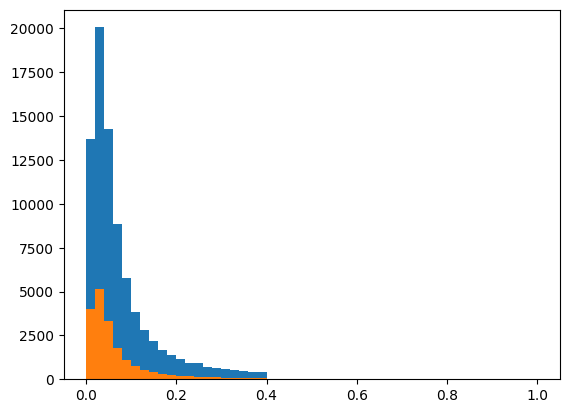

In [236]:
mj_mass,mj_pt,mj_deltaR,mj_mu = getMatchedArrays(events)
tj_mass,tj_pt,tj_deltaR,tj_mu = getMatchedArrays(trig_events)

#print(len(ak.flatten(idx_matched)))
# plt.yscale("log")
#print(ak.flatten(deltaR_sorted[idx_matched]))

trigger efficiency inclusive 0.39304881165346284


ValueError: operands could not be broadcast together with shapes (1,1538) (1,3913) 

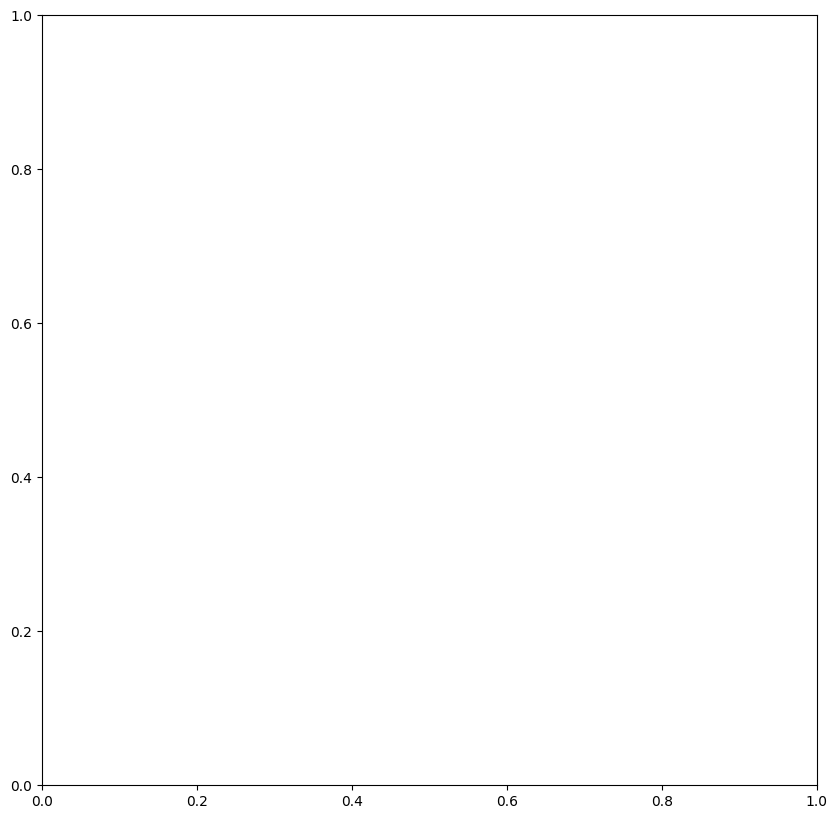

In [244]:
#events.Jet[idx_jets[idx_matched]][10]
do1DHist(mj_mass,tj_mass,50,"m_{jj} (GeV)")
do1DHist(mj_pt,tj_pt,50,"p_{T}^{jj} (GeV)")
do1DHist(mj_deltaR,tj_deltaR,50,"#deltaR ")
do1DHist(mj_mu,tj_mu,50,"Muon pT (GeV) ")

In [415]:
#idx_matched = get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
#idx_matched = get_valid_pairs_index(idx_quark, idx_jets, ak.ArrayBuilder()).snapshot()
print(len(idx_matched))
print()
# The invalid jet matches result in a None value. Only non-None values are selected.
matched_quarks = bquarks[idx_quark[idx_matched]]
matched_jets = events.Jet[idx_jets[idx_matched]]
deltaR_matched = deltaRcut[idx_matched]
print(len(matched_jets))
print(len(matched_quarks))

176000

176000
176000


In [47]:
events["PartonMatched"] = ak.with_field(matched_quarks, deltaR_matched, "dRMatchedJet", behavior=matched_quarks.behavior)
events["JetMatched"] = ak.with_field(matched_jets, deltaR_matched, "dRMatchedJet", behavior=matched_jets.behavior) 
print(len(events.JetMatched[ak.num(events.JetMatched[~ak.is_none(events.JetMatched, axis=1)])>1]))
pt_corr = events.Jet.pt*events.Jet.bRegCorr
#events["JetMatched"] = ak.with_field(events.JetMatched, pt_corr, "pt", behavior=events.JetMatched.behavior)
events.Jet = ak.with_field(events.Jet, pt_corr, "pt", behavior=events.Jet.behavior)
#print(events.JetMatched.fields)
trigger = events[mask_HLT]
jj = get_dijet(trigger.Jet[mask_mu1])

dpt = events.PartonMatched.pt - events.JetMatched.pt 
dpt_corr = events.PartonMatched.pt - events.JetMatched.pt*events.JetMatched.bRegCorr 

print('dpt',ak.flatten(dpt[0:100]))

#print(events.JetMatched.type)
#caster = ak.flatten(jj.dRdiJet[jj.mass!=-1],axis =0)
mass = caster = ak.flatten(jj.mass[(jj.mass!=-1)  & (jj.mass<500) ],axis =0)
print(len(caster[caster!=0]))

#print(events.JetMatched.partonFlavour)

#plt.hist(ak.flatten(dpt_corr), bins=50)
plt.hist(caster, bins=50)



NameError: name 'matched_quarks' is not defined

In [429]:
ak.num(events.PartonMatched, axis=1)

<Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='176000 * int64'>

### Check profiling

In [ ]:
%%snakeviz 
results1 = get_valid_pairs_masks(idx_quark, idx_jets)

In [ ]:
%%snakeviz 
results3 = get_valid_pairs_numba(idx_quark, idx_jets, ak.ArrayBuilder())

### Check the performance of first part of the algo

In [ ]:
%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2) 

In [ ]:
%%timeit
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian

In [ ]:
%%timeit  pass
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)


In [ ]:
%%timeit pass
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]

In [ ]:
%%timeit pass
pairs_sorted = pairs[idx_pairs_sorted]


In [ ]:
%%timeit pass
idx_quark, idx_jets = ak.unzip(pairs_sorted)

In [ ]:
%%timeit
# Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
dr_min = 0.4
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
# keeping only the pairs with a deltaR min
maskDR = deltaR < dr_min
deltaRcut = deltaR[maskDR] #--> the mask works since we are applying it also to the argcartesian
idx_pairs_sorted = ak.argsort(deltaRcut, axis=1)
pairs = ak.argcartesian([bquarks, events.Jet])[maskDR]
pairs_sorted = pairs[idx_pairs_sorted]
idx_quark, idx_jets = ak.unzip(pairs_sorted)
       

In [ ]:
idx_quark